In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isabellechiu","key":"9acb49850b4f9373cb2e7979909929fb"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls -a

.  ..  .config	kaggle.json  sample_data


In [ ]:
import json
token = {'username':'YOUR-USER-NAME','key':'SOMETHING-VERY-LONG'}
with open('/content/kaggle.json', 'w') as file:
    json.dump(token, file)

!chmod 600 /content/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      
  inflating: train/dog.5521.jpg      
  inflating: train/dog.5522.jpg      

In [ ]:
!pip3 install torch torchvision
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision import datasets, transforms, models
import copy
import tqdm
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


SELF EXPREIENCE:

RuntimeError: Found 0 files in subfolders of: /content/train
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

SOLUTION: Since PyTorch support loading image data from subfolders of data directory, we will have to put all cat images to cats folder and all dog images to dogs folder.

In [ ]:
!mkdir ../content/train/cat
!mkdir ../content/train/dog
!mkdir ../content/val
!mkdir ../content/val/cat
!mkdir ../content/val/dog

In [ ]:
train_dir = "/content/train"
train_dogs_dir = f'{train_dir}/dog'
train_cats_dir = f'{train_dir}/cat'
val_dir = "/content/val"
val_dogs_dir = f'{val_dir}/dog'
val_cats_dir = f'{val_dir}/cat'
print("Printing data dir")
print(os.listdir("/content")) # Shows train, val folders are under data
print("Printing train dir")
!ls {train_dir} | head -n 5 # Shows image files are in train folder
print("Printing train dog dir")
!ls {train_dogs_dir} | head -n 5 # Check the (empty) folder exist
print("Printing train cat dir")
!ls {train_cats_dir} | head -n 5 # Check the (empty) folder exist
print("Printing val dir")
!ls {val_dir} | head -n 5  # Shows subfolder dogs and cats exist
print("Printing val dog dir")
!ls {val_dogs_dir} | head -n 5 # Check the (empty) folder exist
print("Printing val cat dir")
!ls {val_cats_dir} | head -n 5 # Check the (empty) folder exist


Printing data dir
['.config', 'train', 'sampleSubmission.csv', 'val', 'test1.zip', 'test1', 'kaggle.json', 'train.zip', 'sample_data']
Printing train dir
cat
cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
Printing train dog dir
Printing train cat dir
Printing val dir
cat
dog
Printing val dog dir
Printing val cat dir


In [ ]:
import shutil
import re
files = os.listdir(train_dir)
# Move all train cat images to cats folder, dog images to dogs folder
for f in files:
    catSearchObj = re.search("cat", f)
    dogSearchObj = re.search("dog", f)
    if catSearchObj:
        shutil.move(f'{train_dir}/{f}', train_cats_dir)
    elif dogSearchObj:
        shutil.move(f'{train_dir}/{f}', train_dogs_dir)

In [ ]:
print("Printing train dir") # shows cats, dogs subfolders only
!ls {train_dir} | head -n 5
print("Printing train dog dir") # there is now dog images in dogs folder
!ls {train_dogs_dir} | head -n 5
print("Printing train cat dir") # there is now cat images in cats folder
!ls {train_cats_dir} | head -n 5

Printing train dir
cat
dog
Printing train dog dir
dog.0.jpg
dog.10000.jpg
dog.10001.jpg
dog.10002.jpg
dog.10003.jpg
Printing train cat dir
cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg


In [ ]:
##total 25,000 images and 20 % for val dataset might be too much, therefore, 
##just take out 1,000 images for cats and dogs each
##dog
files = os.listdir(train_dogs_dir)
for f in files:
    validationDogsSearchObj = re.search("5\d\d\d", f)
    if validationDogsSearchObj:
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)
print("Printing val dog dir")
!ls {val_dogs_dir} | head -n 5
##cat
files = os.listdir(train_cats_dir)
for f in files:
    validationCatsSearchObj = re.search("5\d\d\d", f)
    if validationCatsSearchObj:
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)
print("Printing val cat dir")
!ls {val_cats_dir} | head -n 5

Printing val dog dir
dog.5000.jpg
dog.5001.jpg
dog.5002.jpg
dog.5003.jpg
dog.5004.jpg
Printing val cat dir
cat.5000.jpg
cat.5001.jpg
cat.5002.jpg
cat.5003.jpg
cat.5004.jpg


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.ImageFolder('/content/train', transform=transform_train)
val_dataset = datasets.ImageFolder('/content/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 50, shuffle=False)

In [ ]:
print(len(training_dataset))
print(len(val_dataset))
classes=training_dataset.classes
print(classes)

23000
2000
['cat', 'dog']


#THERE'S ANOTHER METHOD OF IMAGE VIEWING

https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

 def imshow(inp, title=None):
      """Imshow for Tensor."""
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)
      if title is not None:
          plt.title(title)
      plt.pause(0.001)  # pause a bit so that plots are updated
  # Get a batch of training data
  images, labels = next(iter(dataloaders['train']))
  # Make a grid from batch
  sample_train_images = torchvision.utils.make_grid(inputs)
  imshow(sample_train_images, title=classes)


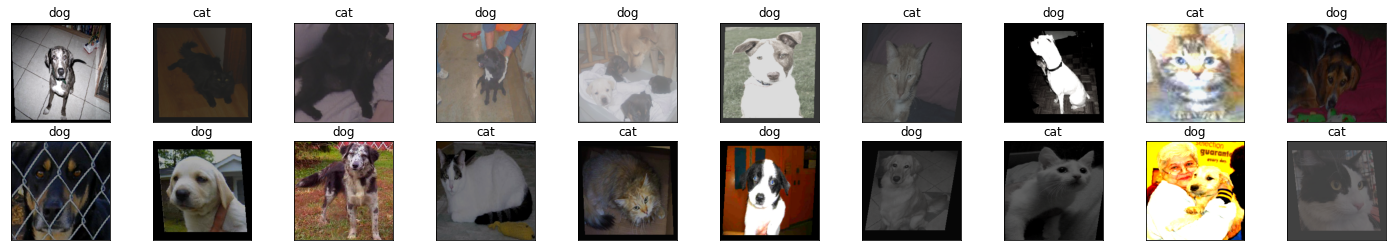

In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

images, labels = next(iter(training_loader))
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
model = models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
import torch.nn as nn

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

2


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)


In [ ]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(val_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(val_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0041, acc 0.8994 
validation loss: 0.0009, validation acc 0.9815 
epoch : 2
training loss: 0.0039, acc 0.9033 
validation loss: 0.0010, validation acc 0.9815 
epoch : 3
training loss: 0.0037, acc 0.9073 
validation loss: 0.0008, validation acc 0.9835 
epoch : 4
training loss: 0.0036, acc 0.9126 
validation loss: 0.0009, validation acc 0.9815 
epoch : 5
training loss: 0.0036, acc 0.9130 
validation loss: 0.0008, validation acc 0.9815 
epoch : 6
training loss: 0.0035, acc 0.9150 
validation loss: 0.0009, validation acc 0.9840 
epoch : 7
training loss: 0.0034, acc 0.9183 
validation loss: 0.0009, validation acc 0.9840 
epoch : 8
training loss: 0.0034, acc 0.9177 
validation loss: 0.0010, validation acc 0.9825 
epoch : 9
training loss: 0.0032, acc 0.9235 
validation loss: 0.0010, validation acc 0.9815 
epoch : 10
training loss: 0.0032, acc 0.9222 
validation loss: 0.0012, validation acc 0.9800 


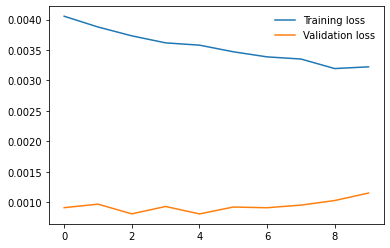

In [ ]:
plt.plot(running_loss_history, label='Training loss')
plt.plot(val_running_loss_history, label='Validation loss')
plt.legend(frameon=False)

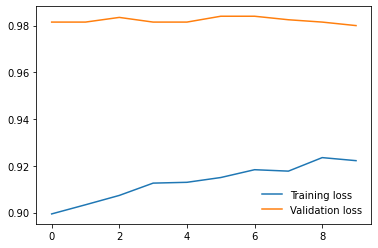

In [ ]:
plt.plot(running_corrects_history, label='Training loss')
plt.plot(val_running_corrects_history, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
from PIL import Image
test_dir='/content/test1'
test_files = os.listdir(test_dir)


In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

testset = CatDogDataset(test_files, test_dir, mode='test', transform = transform)
testloader = DataLoader(testset, batch_size = 50, shuffle=False)

In [ ]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

In [ ]:
submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('DogsvsCats_submission.csv', index=False)
